# Star-forming versus queiscent

In [2]:
import os
import h5py 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [18]:
import corner as DFM

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.sfr.hdf5'))

In [6]:
has_posterior = (bgs['provabgs_z_max'].data != -999.)

In [7]:
bgs = bgs[has_posterior]

In [10]:
logsfr = np.log10(np.median(bgs['provabgs_avgSFR1Gyr_mcmc'].data, axis=1))
logm = bgs['provabgs_logMstar_bf'].data

In [28]:
zlim = (bgs['Z_HP'] < 0.2)

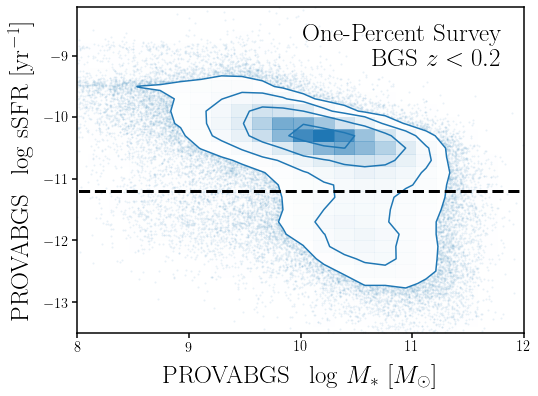

In [38]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

DFM.hist2d(logm[zlim], (logsfr-logm)[zlim], bins=30, range=((7., 12.5), (-14., -8)), 
           color='C0', ax=sub)#sub.scatter(logm, logsfr-logm, s=0.1)
sub.plot([7., 12.5], [-11.2, -11.2], color='k', linestyle='--', linewidth=3)
sub.set_xlabel(r"PROVABGS $~\log$ $M_*$ [$M_\odot$]", labelpad=10, fontsize=25)
sub.set_xlim(8., 12.)
sub.set_xticks([8., 9., 10., 11., 12.])
sub.set_ylabel(r"PROVABGS $~\log$ sSFR [${\rm yr}^{-1}$]", labelpad=10, fontsize=25)
sub.set_ylim(-13.5, -8.2)
sub.text(0.95, 0.95, r'One-Percent Survey'+'\n'+r'BGS $z < 0.2$', 
         ha='right', va='top', fontsize=25, transform=sub.transAxes)
fig.savefig('../figs/sfq.pdf', bbox_inches='tight')